<a href="https://colab.research.google.com/github/yassmin1/Deep_Learning/blob/main/Plants_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Plant Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Label.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

## Importing necessary libraries

In [184]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential,Model                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix
from sklearn.preprocessing import LabelBinarizer
# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend
from keras.callbacks import ReduceLROnPlateau
import random
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [185]:
# Mount Google drive to access the dataset
# Run the below code if you using google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [186]:
# Load the image file of dataset
images = np.load('/content/drive/MyDrive/Colab Notebooks/DL_ComputerImaging/project_transfere_learning/images.npy')

# Load the labels file of dataset
labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DL_ComputerImaging/project_transfere_learning/Labels.csv')

In [187]:
labels.columns

Index(['Label'], dtype='object')

## Data Overview

### Understand the shape of the dataset

In [188]:
print(images.shape)         #
print(labels.shape)         #

(4750, 128, 128, 3)
(4750, 1)


## Exploratory Data Analysis

### Plotting random images from each of the class

In [189]:
def plot_images(images,labels):
  num_classes=12                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))
                                                # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

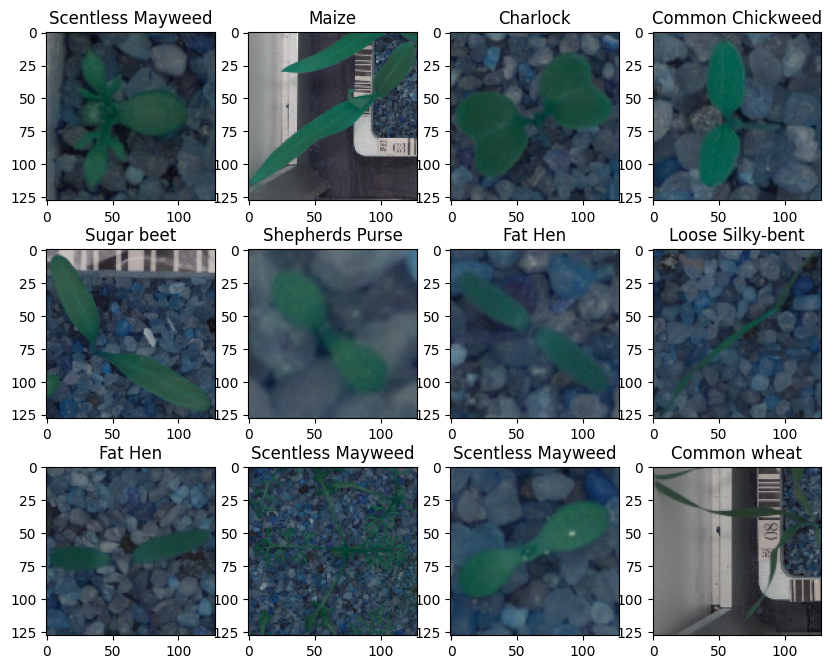

In [190]:
plot_images(images,labels)   #

Obs:The images have a high contrast between the plants and the background

### Checking the distribution of the target variable

(array([  0., 100., 200., 300., 400., 500., 600., 700.]),
 [Text(0.0, 0, '0'),
  Text(100.0, 0, '100'),
  Text(200.0, 0, '200'),
  Text(300.0, 0, '300'),
  Text(400.0, 0, '400'),
  Text(500.0, 0, '500'),
  Text(600.0, 0, '600'),
  Text(700.0, 0, '700')])

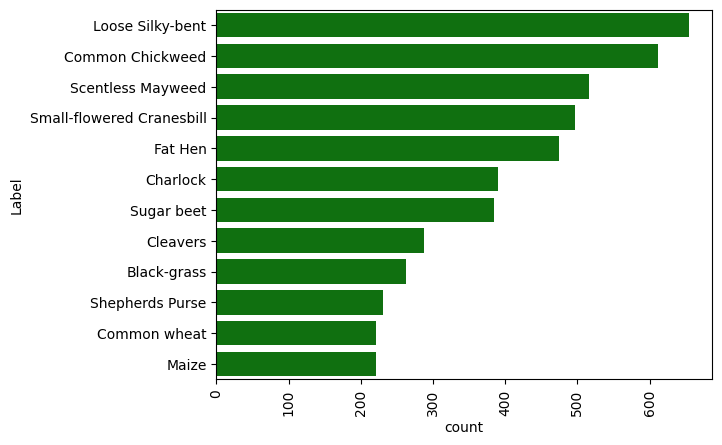

In [191]:
sns.countplot(y=labels['Label'],color='green',order=labels['Label'].value_counts().reset_index()['index'].tolist())            # Complete the code to check for data imbalance
plt.xticks(rotation='vertical')

Text(0.5, 1.0, 'Plant seedlings classes')

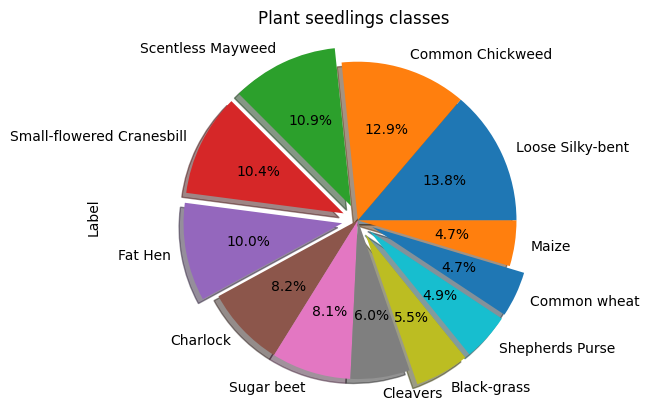

In [192]:
labels['Label'].value_counts().plot.pie(y='Label', autopct='%1.1f%%',
                 legend=False,
                    explode=(0, 0, 0.1,0.1,0.1,0,0,0,0.1,0.1,0.1,0),
                   shadow=True, startangle=0)

plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

plt.title('Plant seedlings classes')


Obs: the labels are inbalanced which will affect the model results


## Data Pre-Processing

### Converting the BGR images to RGB images.

In [193]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  #images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2HLS)

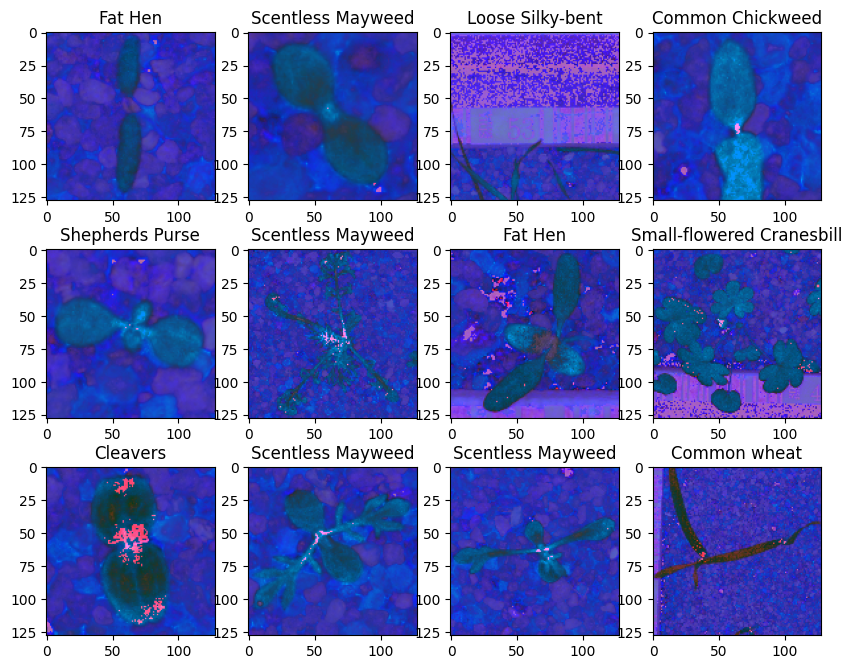

In [173]:
plot_images(images,labels)

### Resizing images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [194]:
images_decreased=[]
height = 64                    # define the height
width =  64                    # define the width
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

**Image before resizing**

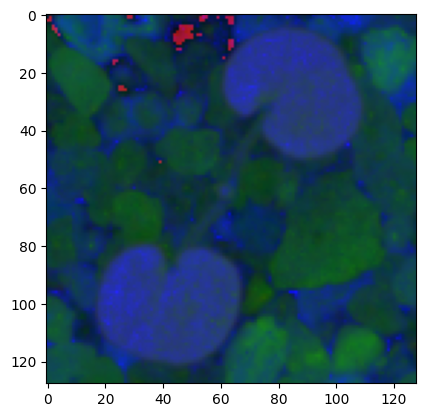

In [195]:
plt.imshow(images[5])

**Image after resizing**

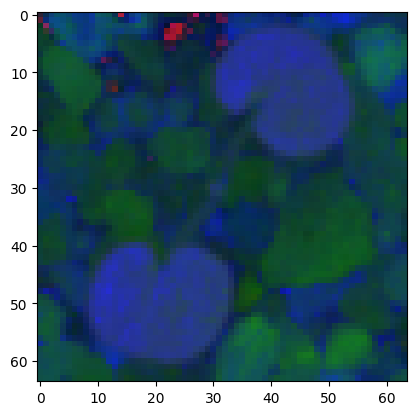

In [196]:
plt.imshow(images_decreased[5])

### Data Preparation for Modeling


- As we have less images in our dataset, we will only use 10% of our data for testing, 10% of our data for validation and 80% of our data for training.
- We are using the train_test_split() function from scikit-learn. Here, we split the dataset into three parts, train,test and validation.

In [197]:
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased),labels , test_size=0.1, random_state=42,stratify=labels)   # Complete the code to split the data with test_size as 0.1
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)                       # Complete the code to split the data with test_size as 0.1

In [198]:
# check the shape of train, validation and test data
print(X_train.shape,y_train.shape)
print(X_val.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (3847, 1)
(475, 64, 64, 3) (475, 1)


### Encoding the target labels

In [199]:
# Convert labels from names to one hot vectors.
# We have already used encoding methods like onehotencoder and labelencoder earlier so now we will be using a new encoding method called labelBinarizer.
# Labelbinarizer works similar to onehotencoder

enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

In [200]:
y_train_encoded.shape,y_val_encoded.shape,y_test_encoded.shape

((3847, 12), (428, 12), (475, 12))

In [201]:
y_train.Label[:].count()

3847

### Data Normalization

Since the **image pixel values range from 0-255**, our method of normalization here will be **scaling** - we shall **divide all the pixel values by 255 to standardize the images to have values between 0-1.**

In [202]:
#  normalize the image pixels of train, test and validation data
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

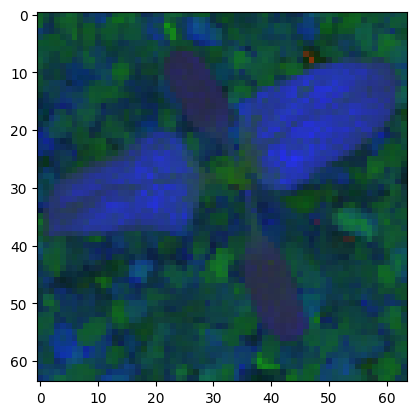

In [203]:
tools_image=X_train_normalized[80].copy()
plt.imshow(tools_image)

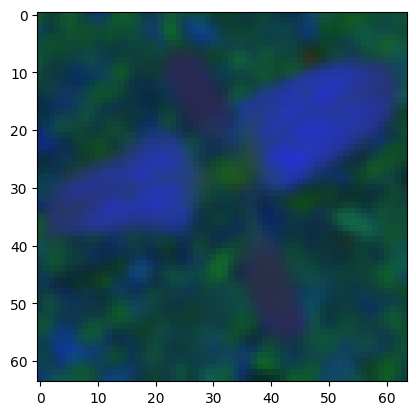

In [204]:
# Import threshold and gray convertor functions
from skimage.filters import threshold_local,try_all_threshold,threshold_otsu,gaussian
from skimage.color import rgb2gray

# Turn the image grayscale
gray_tools_image = rgb2gray(tools_image)
gua_image=gaussian(tools_image)
# Obtain the optimal thresh
thresh = threshold_otsu(gray_tools_image)

# Obtain the binary image by applying thresholding
binary_image = gray_tools_image > thresh

# Show the resulting binary image
#plt.imshow(binary_image,cmap='gray')
plt.imshow(gua_image,cmap='gray')

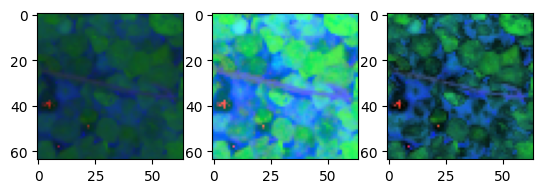

In [205]:
# Import the required module
from skimage import exposure

# Use histogram equalization to improve the contrast
image_eq =  exposure.equalize_hist(X_train[100])

# Show the original and resulting image
fig,(ax1,ax2,ax3)=plt.subplots(1,3)
ax1.imshow(X_train[100])
ax2.imshow(image_eq)
adapthist_eq_image = exposure.equalize_adapthist(X_train[100], clip_limit=0.03)
ax3.imshow(adapthist_eq_image)

# Primarily Model

In [206]:
# Clearing backend
backend.clear_session()

In [207]:
# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [208]:
# Intializing a sequential model
model1 = Sequential()
# add the first conv layer with 128 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model1.add(Conv2D(128, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# add the max pooling to reduce the size of output of first conv layer
model1.add(MaxPooling2D((2, 2), padding = 'same'))

# create two similar convolution and max-pooling layers activation = relu
model1.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

model1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

# flatten the output of the conv layer after max pooling to make it ready for creating dense connections
model1.add(Flatten())

# Complete the code to add a fully connected dense layer with 16 neurons
model1.add(Dense(16, activation='relu'))
model1.add(Dropout(0.3))
# Complete the code to add the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model1.add(Dense(12, activation='softmax'))

# Complete the code to use the Adam Optimizer
opt=Adam()
# Complete the code to Compile the model using suitable metric for loss fucntion
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Complete the code to generate the summary of the model
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 32)          0

<b> Fitting the model on the train data

In [209]:
# fit the model on train and also using the validation data for validation
history_1 = model1.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2
)

Epoch 1/30
121/121 - 3s - loss: 2.3612 - accuracy: 0.1736 - val_loss: 2.2325 - val_accuracy: 0.3388 - 3s/epoch - 26ms/step
Epoch 2/30
121/121 - 1s - loss: 2.0830 - accuracy: 0.3174 - val_loss: 1.9708 - val_accuracy: 0.3528 - 1s/epoch - 10ms/step
Epoch 3/30
121/121 - 1s - loss: 1.9123 - accuracy: 0.3621 - val_loss: 1.7095 - val_accuracy: 0.4463 - 1s/epoch - 11ms/step
Epoch 4/30
121/121 - 1s - loss: 1.7932 - accuracy: 0.3850 - val_loss: 1.6945 - val_accuracy: 0.4463 - 1s/epoch - 11ms/step
Epoch 5/30
121/121 - 1s - loss: 1.6800 - accuracy: 0.4193 - val_loss: 1.5699 - val_accuracy: 0.4509 - 1s/epoch - 11ms/step
Epoch 6/30
121/121 - 1s - loss: 1.5843 - accuracy: 0.4442 - val_loss: 1.4327 - val_accuracy: 0.5210 - 1s/epoch - 10ms/step
Epoch 7/30
121/121 - 1s - loss: 1.5306 - accuracy: 0.4606 - val_loss: 1.4397 - val_accuracy: 0.5117 - 1s/epoch - 9ms/step
Epoch 8/30
121/121 - 1s - loss: 1.4460 - accuracy: 0.4858 - val_loss: 1.3971 - val_accuracy: 0.5350 - 1s/epoch - 10ms/step
Epoch 9/30
121/12

**Model Evaluation**

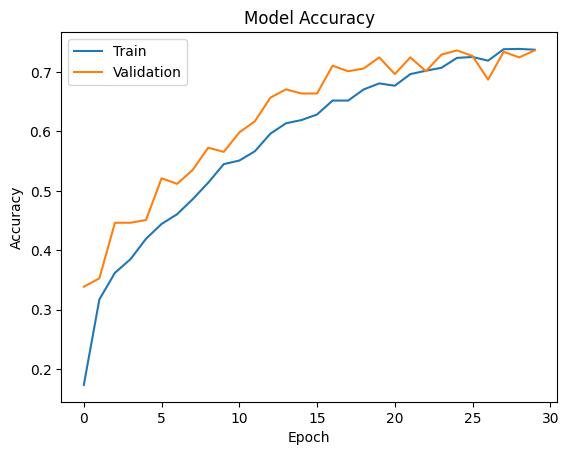

In [210]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Evaluate the model on test data**

In [211]:
accuracy = model1.evaluate(X_test_normalized, y_test_encoded, verbose=2)    #  evaluate the model on test data

15/15 - 0s - loss: 1.0034 - accuracy: 0.7474 - 89ms/epoch - 6ms/step


**Plotting the Confusion Matrix**

In [212]:
# Here we would get the output as probablities for each category
y_pred=model1.predict(X_test_normalized)                          # predict the output probabilities

15/15 [==============================] - 0s 4ms/step


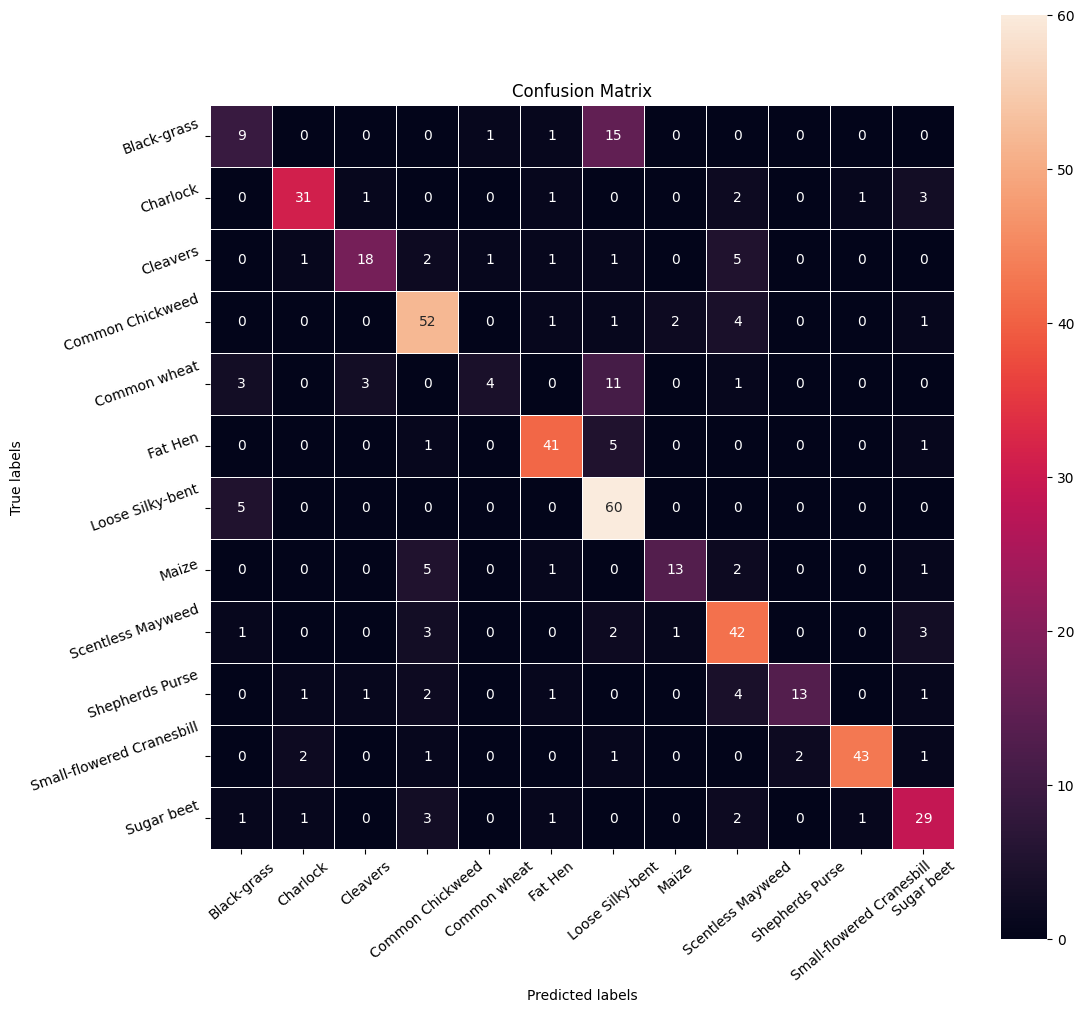

In [213]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)              # Complete the code to plot the confusion matrix
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

**Plotting Classification Report**

In [214]:
from sklearn import metrics
# Plotting the classification report
cr=metrics.classification_report(y_test_arg,y_pred_arg)     # plot the classification report
print(cr)

              precision    recall  f1-score   support

           0       0.47      0.35      0.40        26
           1       0.86      0.79      0.83        39
           2       0.78      0.62      0.69        29
           3       0.75      0.85      0.80        61
           4       0.67      0.18      0.29        22
           5       0.85      0.85      0.85        48
           6       0.62      0.92      0.75        65
           7       0.81      0.59      0.68        22
           8       0.68      0.81      0.74        52
           9       0.87      0.57      0.68        23
          10       0.96      0.86      0.91        50
          11       0.72      0.76      0.74        38

    accuracy                           0.75       475
   macro avg       0.75      0.68      0.70       475
weighted avg       0.76      0.75      0.74       475



# Model Performance Improvement

###1.**Reducing the Learning Rate:**

**ReduceLRonPlateau()** is a function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [215]:
# Code to monitor val_accuracy
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)


##2.**Data Augmentation**

In [216]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [217]:
# Complete the code to set the rotation_range to 20
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )

In [218]:
# Intializing a sequential model
model2 = Sequential()

# add the first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# add max pooling to reduce the size of output of first conv layer
model2.add(MaxPooling2D((2, 2), padding = 'same'))


model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(BatchNormalization())

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model2.add(Flatten())

# Adding a fully connected dense layer with 16 neurons
model2.add(Dense(16, activation='relu'))

# add dropout with dropout_rate=0.3
model2.add(Dropout(0.3))
# add the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model2.add(Dense(12, activation='softmax'))

#initialize Adam Optimimzer
opt=Adam()
# ompile model
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 16, 16, 32)        128       
 Normalization)                                                  
                                                        

<b> Fitting the model on the train data

In [219]:
# fit the model on train data with batch_size=64 and epochs=30
# Epochs
epochs = 30
# Batch size
batch_size = 64

history = model2.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       shuffle=False),
                                       epochs=epochs,
                                       steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                                       validation_data=(X_val_normalized,y_val_encoded),
                                       verbose=1,callbacks=[learning_rate_reduction])

Epoch 1/30
60/60 [==============================] - 8s 104ms/step - loss: 2.0851 - accuracy: 0.2628 - val_loss: 2.3769 - val_accuracy: 0.1916 - lr: 0.0010
Epoch 2/30
60/60 [==============================] - 5s 77ms/step - loss: 1.6964 - accuracy: 0.3910 - val_loss: 2.2797 - val_accuracy: 0.2827 - lr: 0.0010
Epoch 3/30
60/60 [==============================] - 7s 111ms/step - loss: 1.5057 - accuracy: 0.4660 - val_loss: 2.1588 - val_accuracy: 0.4813 - lr: 0.0010
Epoch 4/30
60/60 [==============================] - 5s 80ms/step - loss: 1.3958 - accuracy: 0.5107 - val_loss: 1.9861 - val_accuracy: 0.4603 - lr: 0.0010
Epoch 5/30
60/60 [==============================] - 5s 78ms/step - loss: 1.2805 - accuracy: 0.5453 - val_loss: 1.6134 - val_accuracy: 0.6565 - lr: 0.0010
Epoch 6/30
60/60 [==============================] - 6s 106ms/step - loss: 1.1694 - accuracy: 0.5858 - val_loss: 1.3940 - val_accuracy: 0.6238 - lr: 0.0010
Epoch 7/30
60/60 [==============================] - 5s 77ms/step - loss: 

**Model Evaluation**

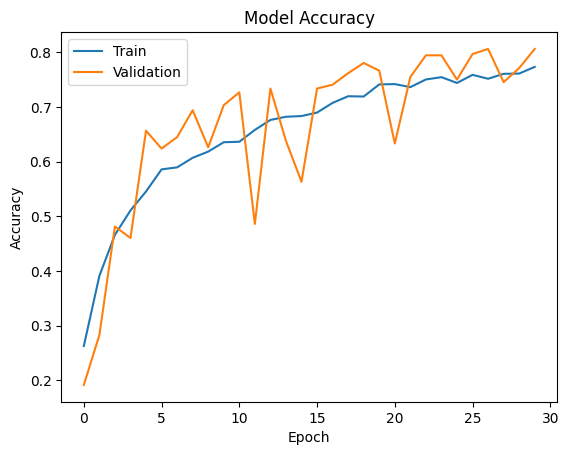

In [220]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Evaluate the model on test data**

In [221]:
accuracy = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)  # evaluate the model on test data

15/15 - 0s - loss: 0.7434 - accuracy: 0.7958 - 69ms/epoch - 5ms/step


**Plotting the Confusion Matrix**

In [222]:
# Complete the code to obtain the output probabilities
y_pred=model2.predict(X_test_normalized)

15/15 [==============================] - 0s 3ms/step


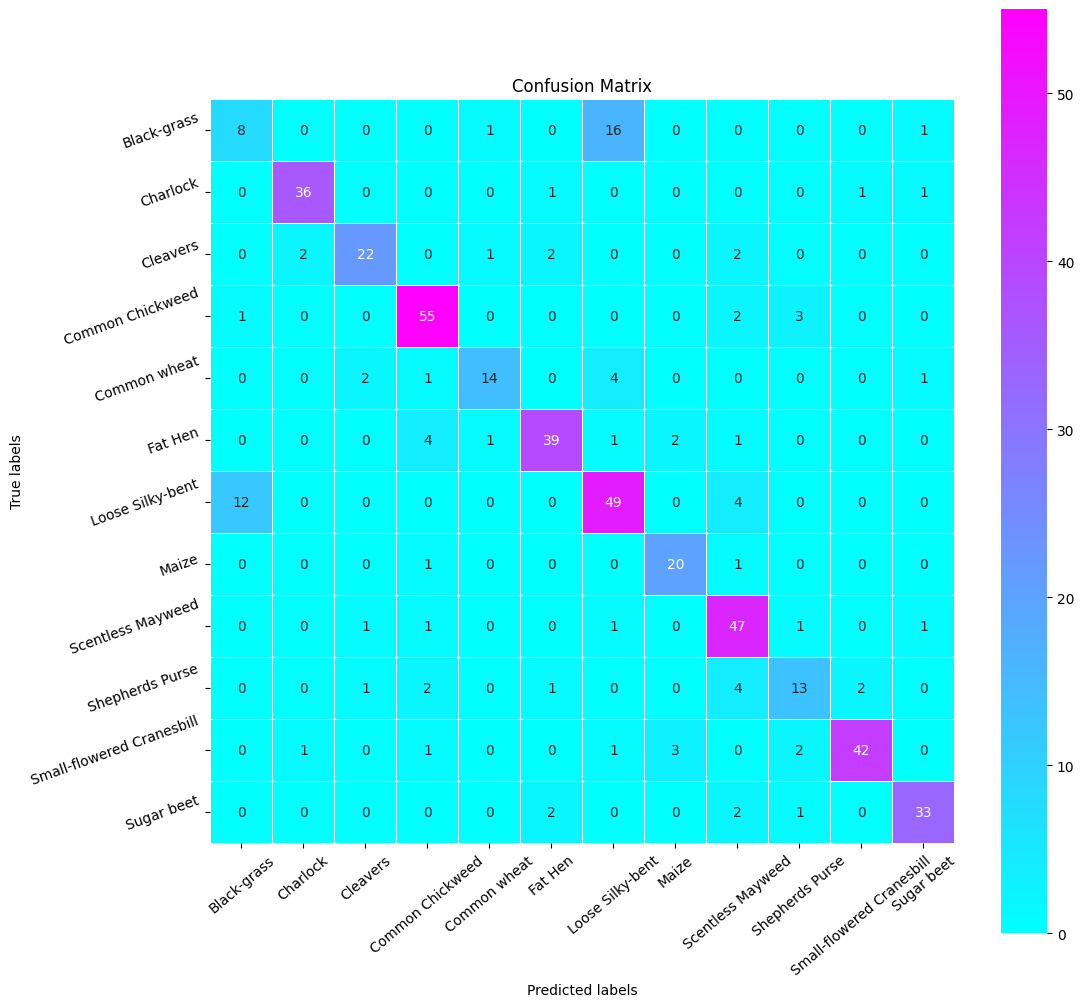

In [223]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)     # Complete the code to obatin the confusion matrix
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax,cmap='cool'
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

**Plotting Classification Report**

In [224]:
# Plotting the classification report
from sklearn import metrics
cr=metrics.classification_report(y_test_arg,y_pred_arg,target_names=enc.classes_,output_dict=False)    # Complete the code to plot the classification report
print(cr)

                           precision    recall  f1-score   support

              Black-grass       0.38      0.31      0.34        26
                 Charlock       0.92      0.92      0.92        39
                 Cleavers       0.85      0.76      0.80        29
         Common Chickweed       0.85      0.90      0.87        61
             Common wheat       0.82      0.64      0.72        22
                  Fat Hen       0.87      0.81      0.84        48
         Loose Silky-bent       0.68      0.75      0.72        65
                    Maize       0.80      0.91      0.85        22
        Scentless Mayweed       0.75      0.90      0.82        52
          Shepherds Purse       0.65      0.57      0.60        23
Small-flowered Cranesbill       0.93      0.84      0.88        50
               Sugar beet       0.89      0.87      0.88        38

                 accuracy                           0.80       475
                macro avg       0.78      0.77      0.77    

##3.Adding more Augmented images

In [225]:
# Code to monitor val_accuracy
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [226]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [227]:
from PIL import Image
def myFunc_brit(image):
    image = np.array(image)
    im=tf.image.adjust_brightness(cv2.cvtColor((image*255).astype(np.uint8),cv2.COLOR_RGB2HSV),0.1)
    return im/255
def myFunc_sat(image):
    image = np.array(image)
    im=tf.image.adjust_saturation(cv2.cvtColor((image*255).astype(np.uint8),cv2.COLOR_RGB2HSV),0.9)
    return im/255
train_datagen = ImageDataGenerator(
                              rotation_range=30,

    #width_shift_range=0.2,
    #height_shift_range=0.2,
    shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True,
    #brightness_range=[0.5,0.6],
    #preprocessing_function = myFunc_sat,

                              fill_mode='nearest'
                              )
#X_train_normalized[3]
#plt.imshow(myFunc_brit(X_train_normalized[3]))

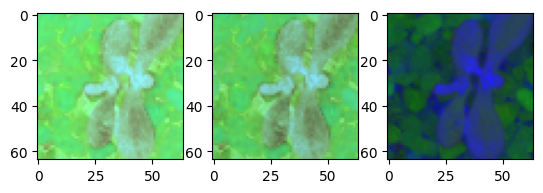

In [228]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3)
ax1.imshow(myFunc_brit(X_train_normalized[3]))
ax2.imshow(myFunc_sat(X_train_normalized[3]))
ax3.imshow(X_train_normalized[3])


In [229]:
# Intializing a sequential model
model3 = Sequential()

# Complete the code to add the first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model3.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Complete the code to add max pooling to reduce the size of output of first conv layer
model3.add(MaxPooling2D((2, 2), padding = 'same'))


model3.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model3.add(MaxPooling2D((2, 2), padding = 'same'))
model3.add(BatchNormalization())

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model3.add(Flatten())

# Adding a fully connected dense layer with 16 neurons
model3.add(Dense(16, activation='relu'))

# Complete the code to add dropout with dropout_rate=0.3
model3.add(Dropout(0.3))
# Complete the code to add the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model3.add(Dense(12, activation='softmax'))

# Complete the code to initialize Adam Optimimzer
opt=Adam()
# Complete the code to Compile model
model3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 16, 16, 32)        128       
 Normalization)                                                  
                                                        

In [230]:
np.unique(y_train.values)

array(['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
       'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
       'Scentless Mayweed', 'Shepherds Purse',
       'Small-flowered Cranesbill', 'Sugar beet'], dtype=object)

In [231]:
from sklearn.utils import class_weight
epochs = 30
# Batch size
batch_size = 64
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(y_train),
                                                 y=y_train.values.reshape(-1))
class_weights = dict(enumerate(class_weights))


history3 = model3.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       shuffle=False),
                                       epochs=epochs,
                                       steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                                       validation_data=(X_val_normalized,y_val_encoded),
                                     callbacks=[learning_rate_reduction],class_weight=class_weights,
                       )

Epoch 1/30
60/60 [==============================] - 8s 88ms/step - loss: 2.2162 - accuracy: 0.1879 - val_loss: 2.4086 - val_accuracy: 0.0911 - lr: 0.0010
Epoch 2/30
60/60 [==============================] - 5s 81ms/step - loss: 1.8587 - accuracy: 0.2987 - val_loss: 2.2894 - val_accuracy: 0.2103 - lr: 0.0010
Epoch 3/30
60/60 [==============================] - 7s 113ms/step - loss: 1.6942 - accuracy: 0.3658 - val_loss: 2.2335 - val_accuracy: 0.2360 - lr: 0.0010
Epoch 4/30
60/60 [==============================] - 5s 78ms/step - loss: 1.5682 - accuracy: 0.4227 - val_loss: 2.0982 - val_accuracy: 0.3505 - lr: 0.0010
Epoch 5/30
60/60 [==============================] - 5s 84ms/step - loss: 1.4285 - accuracy: 0.4494 - val_loss: 1.8923 - val_accuracy: 0.4533 - lr: 0.0010
Epoch 6/30
60/60 [==============================] - 5s 77ms/step - loss: 1.3145 - accuracy: 0.5221 - val_loss: 2.0422 - val_accuracy: 0.2523 - lr: 0.0010
Epoch 7/30
60/60 [==============================] - 7s 112ms/step - loss: 1

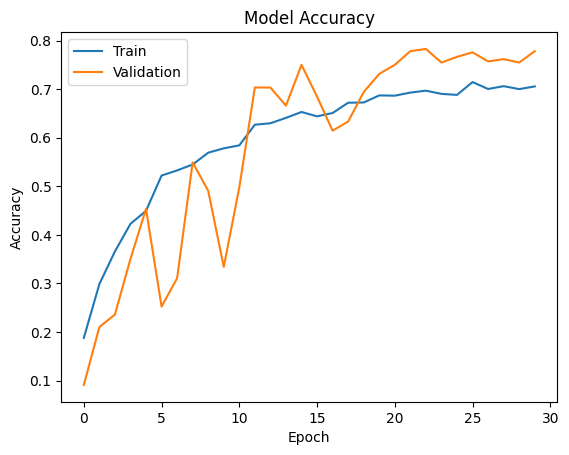

In [232]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [233]:
accuracy = model3.evaluate(X_test_normalized, y_test_encoded, verbose=2)  # evaluate the model on test data

15/15 - 0s - loss: 0.8096 - accuracy: 0.7579 - 71ms/epoch - 5ms/step


In [234]:
# obtain the output probabilities
y_pred_model3=model3.predict(X_test_normalized)

15/15 [==============================] - 0s 3ms/step


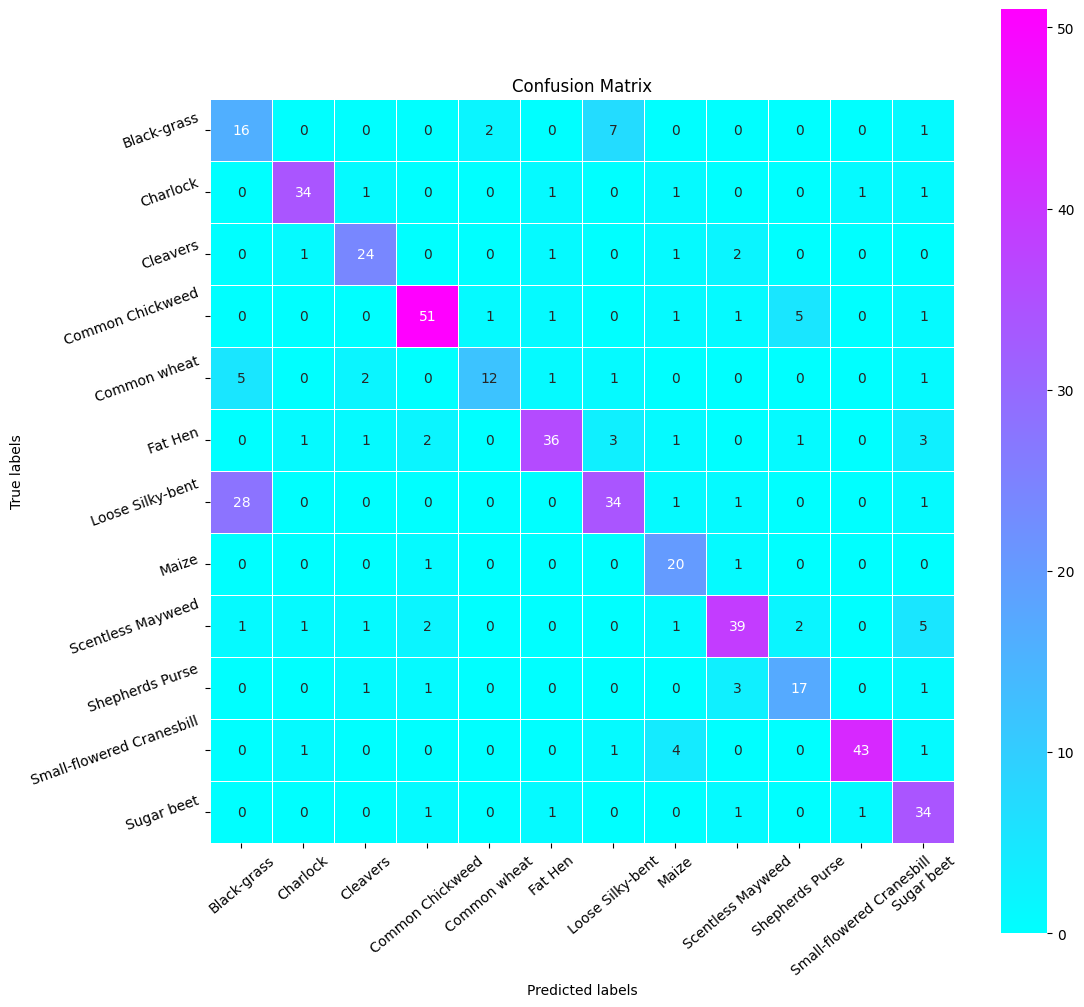

In [235]:
# categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred_model3,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)     #obatin the confusion matrix
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,cmap='cool',
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

In [236]:
from sklearn import metrics
cr=metrics.classification_report(y_test_arg,y_pred_arg,target_names=enc.classes_,output_dict=False)     # plot the classification report
print(cr)

                           precision    recall  f1-score   support

              Black-grass       0.32      0.62      0.42        26
                 Charlock       0.89      0.87      0.88        39
                 Cleavers       0.80      0.83      0.81        29
         Common Chickweed       0.88      0.84      0.86        61
             Common wheat       0.80      0.55      0.65        22
                  Fat Hen       0.88      0.75      0.81        48
         Loose Silky-bent       0.74      0.52      0.61        65
                    Maize       0.67      0.91      0.77        22
        Scentless Mayweed       0.81      0.75      0.78        52
          Shepherds Purse       0.68      0.74      0.71        23
Small-flowered Cranesbill       0.96      0.86      0.91        50
               Sugar beet       0.69      0.89      0.78        38

                 accuracy                           0.76       475
                macro avg       0.76      0.76      0.75    

# Transfer Learning with Data Agumentation
We will be loading a pre-built architecture - VGG16, which was trained on the ImageNet dataset and finished runner-up in the ImageNet competition in 2014. Below is a schematic of the VGG16 model.

For training VGG16, we will directly use the convolutional and pooling layers and freeze their weights i.e. no training will be done on them. We will remove the already-present fully-connected layers and add our own fully-connected layers for this binary classification task.

In [237]:
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.applications.xception import Xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)


In [238]:
# Clearing backend
backend.clear_session()


In [239]:
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [240]:
# Loading VGG16 model
vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (64,64,3))
#vgg_model.get_layer('block5_pool')


In [241]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [242]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [243]:
# Initializing the model
new_model = Sequential()

# Adding the convolutional part of the VGG16 model from above
new_model.add(vgg_model)
# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
new_model.add(Flatten())

# Adding a fully connected dense layer with 16 neurons
new_model.add(Dense(64, activation='relu'))
new_model.add(Dense(32, activation='relu'))
# add dropout with dropout_rate=0.3
new_model.add(Dropout(0.3))
# add the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
new_model.add(Dense(12, activation='softmax'))




In [244]:
# Compiling the model
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Summary of the model
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 12)                396       
                                                                 
Total params: 14848300 (56.64 MB)
Trainable params: 1336

In [245]:
train_datagen = ImageDataGenerator(
                              rotation_range=20,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True,
                              #preprocessing_function = myFunc,

                              fill_mode='nearest'
                              )
# Epochs
epochs = 30
# Batch size
batch_size =64

history = new_model.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       shuffle=False),
                                       epochs=epochs,
                                       steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                                       validation_data=(X_val_normalized,y_val_encoded),
                                       verbose=1,callbacks=[learning_rate_reduction])

Epoch 1/30
60/60 [==============================] - 8s 93ms/step - loss: 2.3317 - accuracy: 0.2017 - val_loss: 2.1445 - val_accuracy: 0.3411 - lr: 0.0010
Epoch 2/30
60/60 [==============================] - 7s 117ms/step - loss: 2.1234 - accuracy: 0.2871 - val_loss: 1.9375 - val_accuracy: 0.3855 - lr: 0.0010
Epoch 3/30
60/60 [==============================] - 6s 92ms/step - loss: 1.9412 - accuracy: 0.3574 - val_loss: 1.8058 - val_accuracy: 0.4252 - lr: 0.0010
Epoch 4/30
60/60 [==============================] - 7s 111ms/step - loss: 1.8360 - accuracy: 0.3870 - val_loss: 1.6741 - val_accuracy: 0.4579 - lr: 0.0010
Epoch 5/30
60/60 [==============================] - 6s 104ms/step - loss: 1.7327 - accuracy: 0.4132 - val_loss: 1.5618 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/30
60/60 [==============================] - 5s 89ms/step - loss: 1.6454 - accuracy: 0.4430 - val_loss: 1.5326 - val_accuracy: 0.4977 - lr: 0.0010
Epoch 7/30
60/60 [==============================] - 7s 117ms/step - loss:

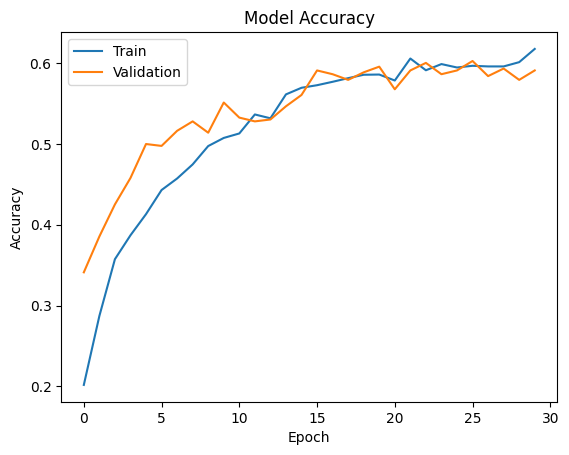

In [246]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [247]:
accuracy = new_model.evaluate(X_test_normalized, y_test_encoded, verbose=2)  # evaluate the model on test data

15/15 - 0s - loss: 1.2229 - accuracy: 0.5747 - 298ms/epoch - 20ms/step


In [248]:
# obtain the output probabilities
y_pred_model3=new_model.predict(X_test_normalized)

15/15 [==============================] - 0s 14ms/step


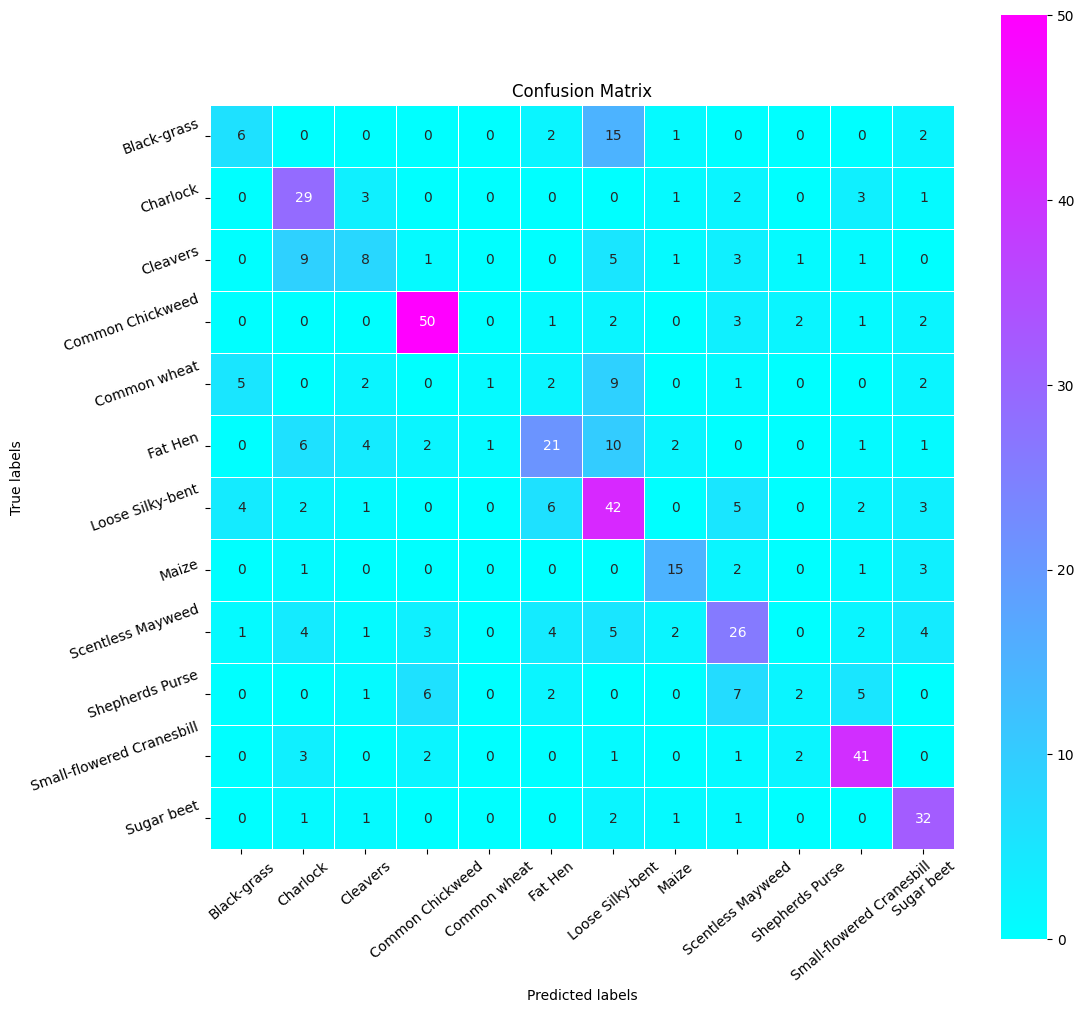

In [249]:
# categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred_model3,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)     #obatin the confusion matrix
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,cmap='cool',
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

In [250]:
from sklearn import metrics
cr=metrics.classification_report(y_test_arg,y_pred_arg,target_names=enc.classes_,output_dict=False)     # plot the classification report
print(cr)

                           precision    recall  f1-score   support

              Black-grass       0.38      0.23      0.29        26
                 Charlock       0.53      0.74      0.62        39
                 Cleavers       0.38      0.28      0.32        29
         Common Chickweed       0.78      0.82      0.80        61
             Common wheat       0.50      0.05      0.08        22
                  Fat Hen       0.55      0.44      0.49        48
         Loose Silky-bent       0.46      0.65      0.54        65
                    Maize       0.65      0.68      0.67        22
        Scentless Mayweed       0.51      0.50      0.50        52
          Shepherds Purse       0.29      0.09      0.13        23
Small-flowered Cranesbill       0.72      0.82      0.77        50
               Sugar beet       0.64      0.84      0.73        38

                 accuracy                           0.57       475
                macro avg       0.53      0.51      0.49    

### Visualizing the prediction

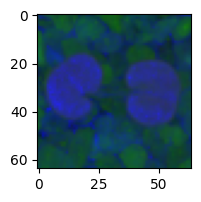

1/1 [==============================] - 0s 38ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


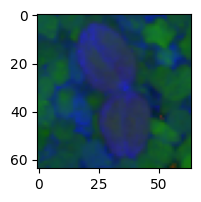

1/1 [==============================] - 0s 22ms/step
Predicted Label ['Cleavers']
True Label Cleavers


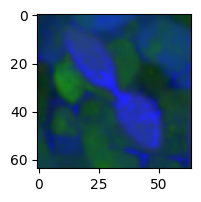

1/1 [==============================] - 0s 18ms/step
Predicted Label ['Common Chickweed']
True Label Common Chickweed


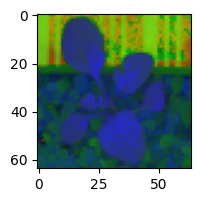

1/1 [==============================] - 0s 19ms/step
Predicted Label ['Shepherds Purse']
True Label Shepherds Purse


In [251]:

# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
## Complete the code to predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
## Complete the code to predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[59],)
plt.show()
## Complete the code to predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[59].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[59])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
## Complete the code to predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])                                              # using inverse_transform() to get the output label from the output vector

##  visualize neural network architecture

In [252]:
from tensorflow.keras.utils import plot_model

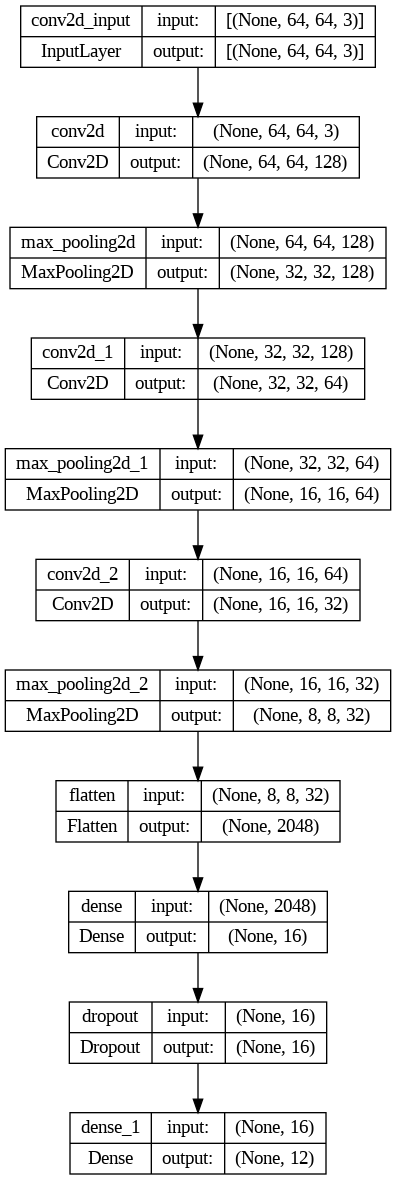

In [253]:
plot_model(model1, to_file='model1.png', show_shapes=True, show_layer_names=True)

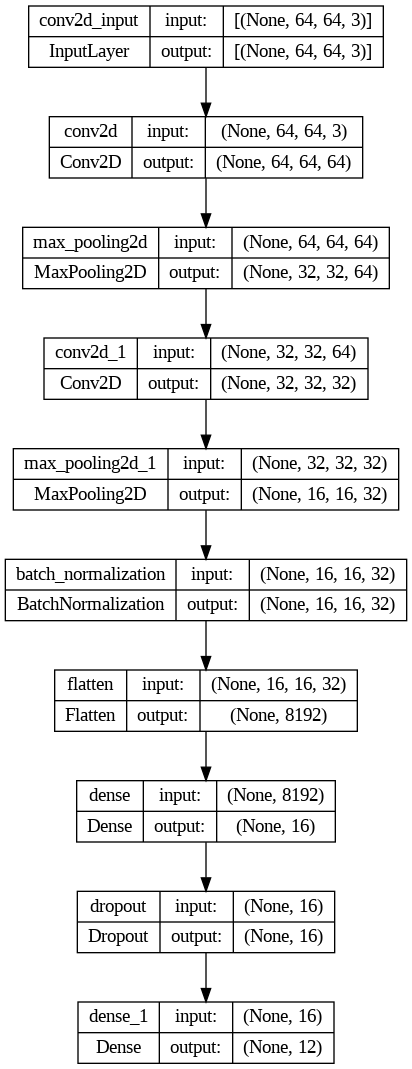

In [254]:
plot_model(model2, to_file='model2.png', show_shapes=True, show_layer_names=True)


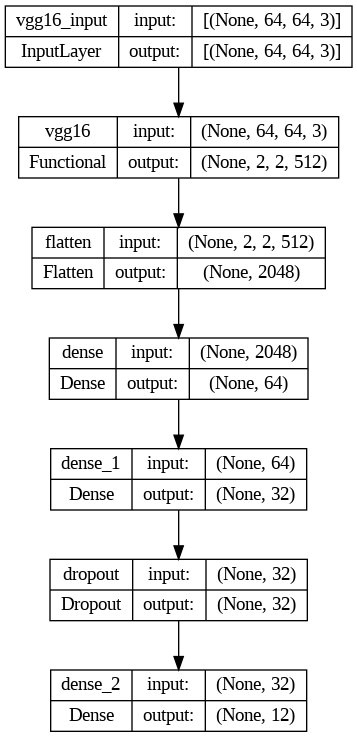

In [255]:
plot_model(new_model,to_file='transfere.png', show_shapes=True, show_layer_names=True)


In [256]:
#!pip install visualkeras

import visualkeras
from PIL import ImageFont


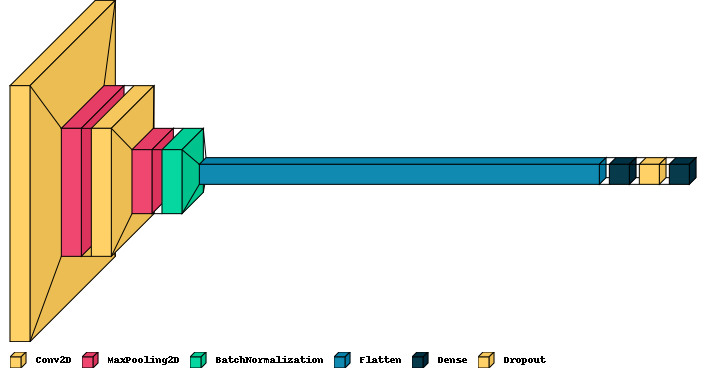

In [257]:
visualkeras.layered_view(model2, legend=True, spacing=10)

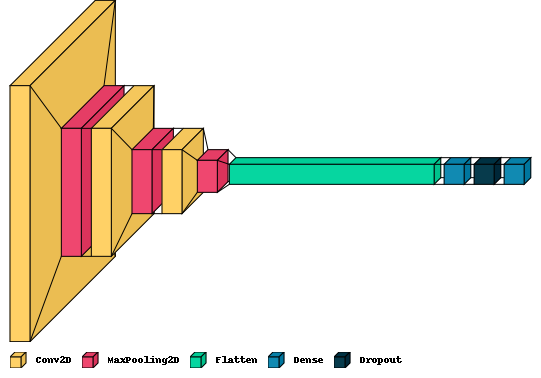

In [258]:
visualkeras.layered_view(model1, legend=True, spacing=10)

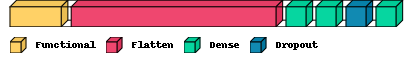

In [259]:
visualkeras.layered_view(new_model, legend=True, spacing=10)

In [ ]:
### in case want to create a mask instead of using HSV color only. follow this link and generate  a mask
#https://docs.opencv.org/4.x/df/d9d/tutorial_py_colorspaces.html

### the best model is the data augmented model:

- Precision measures the accuracy of the positive class predictions. It indicates the percentage of correctly predicted instances among all instances classified as positive. For some classes like "Charlock," "Common Chickweed," "Fat Hen," and "Small-flowered Cranesbill," you achieved high precision, indicating that the model is good at correctly identifying these classes.
- Recall, also known as sensitivity or true positive rate, measures the ability of the model to identify all positive instances correctly. High recall scores for several classes, such as "Charlock," "Common Chickweed," "Maize," and "Scentless Mayweed," indicate that the model is good at capturing most of the positive instances.
- F1-Score is the harmonic mean of precision and recall and provides a balance between the two. For classes with high F1-scores, the model achieves both high precision and recall. Classes like "Charlock," "Common Chickweed," "Fat Hen," and "Small-flowered Cranesbill" have high F1-scores.